In [1]:
import csv
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional


In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

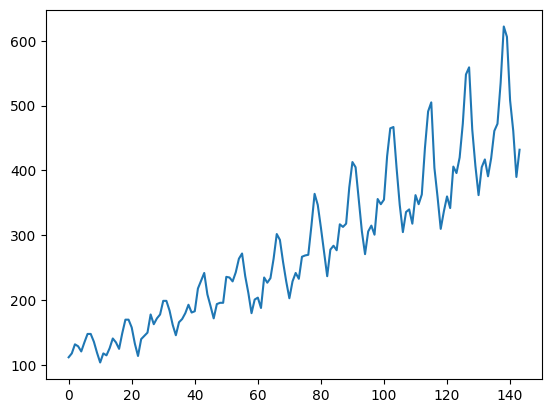

In [3]:
airlines = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv", usecols=[1])
plt.plot(airlines)
plt.show()

dataset = airlines.values
dataset = dataset.astype('float32')

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [15]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
print(train.shape)
print(test.shape)



96 48
(96, 1)
(48, 1)


In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
   dataX, dataY = [], []
   for i in range(len(dataset)-look_back-1):
     a = dataset[i:(i+look_back), 0]
     dataX.append(a)
     dataY.append(dataset[i + look_back, 0])
   return np.array(dataX), np.array(dataY)

In [17]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)


(94, 1)


In [12]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

(94, 1, 1)


In [9]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

2023-12-04 13:15:44.036926: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-04 13:15:44.036967: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-04 13:15:44.036972: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-04 13:15:44.037062: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-04 13:15:44.037088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-12-04 13:15:45.161816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


94/94 - 2s - loss: 0.0269 - 2s/epoch - 20ms/step
Epoch 2/100
94/94 - 1s - loss: 0.0125 - 659ms/epoch - 7ms/step
Epoch 3/100
94/94 - 1s - loss: 0.0102 - 647ms/epoch - 7ms/step
Epoch 4/100
94/94 - 1s - loss: 0.0092 - 639ms/epoch - 7ms/step
Epoch 5/100
94/94 - 1s - loss: 0.0083 - 646ms/epoch - 7ms/step
Epoch 6/100
94/94 - 1s - loss: 0.0072 - 635ms/epoch - 7ms/step
Epoch 7/100
94/94 - 1s - loss: 0.0063 - 656ms/epoch - 7ms/step
Epoch 8/100
94/94 - 1s - loss: 0.0055 - 642ms/epoch - 7ms/step
Epoch 9/100
94/94 - 1s - loss: 0.0048 - 607ms/epoch - 6ms/step
Epoch 10/100
94/94 - 1s - loss: 0.0041 - 657ms/epoch - 7ms/step
Epoch 11/100
94/94 - 1s - loss: 0.0035 - 670ms/epoch - 7ms/step
Epoch 12/100
94/94 - 1s - loss: 0.0031 - 623ms/epoch - 7ms/step
Epoch 13/100
94/94 - 1s - loss: 0.0028 - 619ms/epoch - 7ms/step
Epoch 14/100
94/94 - 1s - loss: 0.0025 - 638ms/epoch - 7ms/step
Epoch 15/100
94/94 - 1s - loss: 0.0023 - 616ms/epoch - 7ms/step
Epoch 16/100
94/94 - 1s - loss: 0.0022 - 619ms/epoch - 7ms/step

In [10]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 13ms/step
Train Score: 22.64 RMSE
Test Score: 49.87 RMSE


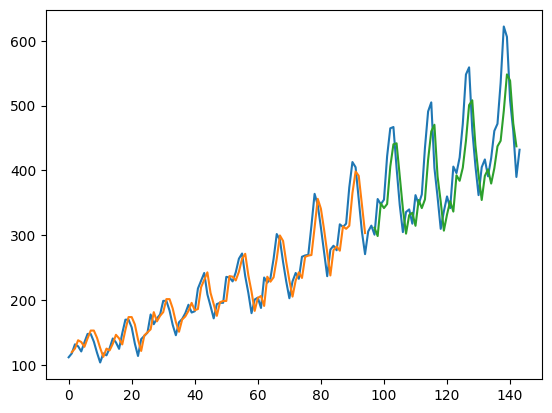

In [11]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()